# Remapping along vertical dimension between 3D curvilinear grids using xgcm with 3D land-sea masks

Documentation : https://xgcm.readthedocs.io/en/latest/

## Chosse the kernel env-esmfxgcm
### Creation of the virtual env (already created)

module load python/gloenv3.10

python3 -m venv --system-site-packages /data/scratch/globc/coquart/DATA_FOR_COMMON_JUPYTER_NOTEBOOKS/env-esmfxgcm

source /data/scratch/globc/coquart/DATA_FOR_COMMON_JUPYTER_NOTEBOOKS/env-esmfxgcm/bin/activate

pip install --upgrade pip

pip install xgcm

pip install ipykernel

deactivate

### Add this environment to your jupyter kernel

source /data/scratch/globc/coquart/DATA_FOR_COMMON_JUPYTER_NOTEBOOKS/env-esmfxgcm/bin/activate

python3 -m ipykernel install --user --name env-esmfxgcm

close and reopen the notebook to see the new kernel env-esmfxgcm and use it

### Remove the environment from your kernel list

jupyter kernelspec list

jupyter kernelspec uninstall env-esmfxgcm

## Preparation


In [1]:
%matplotlib inline
from xgcm import Grid
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from netCDF4 import Dataset
import numpy as np
import math
import xarray as xr
import xesmf as xe
import time as t

/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/pyproj/__init__.py:92: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_DATA (PROJ 9.1+) | PROJ_LIB (PROJ<9.1) or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


In [2]:
begin = t.time()

## Remapping method

In [3]:
method_list = [
    "bilinear",
    "nearest_s2d",
    "nearest_d2s",
    "patch",
]
method=method_list[0]
print("Remapping :"+method)

Remapping :bilinear


## Path to data and names

In [4]:
dir_in="/data/scratch/globc/dcom/CMIP6_TOOLS/xESMF_Interpolation/"
dir_out="/data/scratch/globc/coquart/DATA_FOR_COMMON_JUPYTER_NOTEBOOKS/"

grids="en42D"
gridt="nemo2D"

data_source="grid_msk3D_"+grids+".nc"    
data_target="grid_msk3D_"+gridt+".nc"    

grdslatname=grids+"_lat"
grdslonname=grids+"_lon"
msksname=grids+"_msk"
levsname=grids+"_depth"

grdtlatname=gridt+"_lat"
grdtlonname=gridt+"_lon"
msktname=gridt+"_msk"
levtname=gridt+"_depth"

## Read the source grid 


In [5]:
source_var_grid=[grdslatname,grdslonname]
source_var_mask=[msksname]
source_var_lev=[levsname]
# Open the file(s) and read the data (put in ds_source_grid)
with xr.open_dataset(dir_in+data_source) as ds_source_grid:
    lons=ds_source_grid[grdslonname][:,:]  # xarray object
    #lons=ds_source_grid[grdslonname].data # numpy array
    lats=ds_source_grid[grdslatname][:,:] 
    masks=ds_source_grid[msksname][:,:,:]
    levs=ds_source_grid[levsname][:]
     
ndim_s = masks.shape ; depth_s = ndim_s[0]; y_s = ndim_s[1]; x_s= ndim_s[2];
print("x_s =",x_s)
print("y_s =",y_s)
print("depth_s =",depth_s)

x_s = 360
y_s = 173
depth_s = 42


In [6]:
#print(f'lons {lons[0,0]:.2f}')

## Read the target grid

In [7]:
target_var_grid=[grdtlatname,grdtlonname]
target_var_mask=[msktname]
target_var_lev=[levtname]
# Open the file(s) and read the data (put in ds_target_grid)
with xr.open_dataset(dir_in+data_target) as ds_target_grid:
    lont=ds_target_grid[grdtlonname][:,:]  # xarray object
    #lont=ds_target_grid[grdtlonname].data # numpy array
    latt=ds_target_grid[grdtlatname][:,:]
    maskt=ds_target_grid[msktname][:,:,:]
    levt=ds_target_grid[levtname][:]
    
ndim_t = maskt.shape ; depth_t = ndim_t[0]; y_t = ndim_t[1]; x_t= ndim_t[2];
print("x_t =",x_t)
print("y_t =",y_t)
print("depth_t =",depth_t)

x_t = 362
y_t = 294
depth_t = 75


In [8]:
end = t.time()
print('Runtime to apply the weights to the data in filein is', '{0:.1f}'.format(end - begin), 's')

Runtime to apply the weights to the data in filein is 0.1 s


### Remap source data on vertical axis of target grid using xgcm

In [9]:
begin = t.time()

In [10]:
# File used to calculate the weights:
filein="EN4analysisg10_190001.nc"
varNames1="salinity"
varNames2="temperature"
fileout="so_nemo3D_time0.nc"

In [11]:
# Open the file(s) and read the data 
dfs=xr.load_dataset(dir_in+filein)
dft=xr.load_dataset(dir_in+fileout)

#dft.so[0,:,:,:].to_netcdf(dir_out+"so_nemo3D_time0.nc")

In [12]:
dfs

<xarray.Dataset>
Dimensions:                          (depth: 42, lat: 173, lon: 360, time: 1,
                                      bnds: 2)
Coordinates:
  * depth                            (depth) float32 5.022 15.08 ... 5.35e+03
  * lat                              (lat) float32 -83.0 -82.0 ... 88.0 89.0
  * lon                              (lon) float32 1.0 2.0 3.0 ... 359.0 360.0
  * time                             (time) datetime64[ns] 1900-01-16T12:00:00
Dimensions without coordinates: bnds
Data variables:
    temperature                      (time, depth, lat, lon) float32 nan ... nan
    salinity                         (time, depth, lat, lon) float32 nan ... nan
    temperature_uncertainty          (time, depth, lat, lon) float32 nan ... nan
    salinity_uncertainty             (time, depth, lat, lon) float32 nan ... nan
    temperature_observation_weights  (time, depth, lat, lon) float32 nan ... nan
    salinity_observation_weights     (time, depth, lat, lon) float32 nan ... nan
    time_bnds                        (time, bnds) datetime64[ns] 1900-01-01 1...
    depth_bnds                       (depth, bnds) float32 0.0 10.05 ... 5.5e+03
Attributes: (12/22)
    Conventions:            CF-1.0
    title:                  Temperature and salinity analysis
    DSD_entry_id:           UKMO-L4UHFnd-GLOB-v01
    references:             Website and paper: https://www.metoffice.gov.uk/h...
    institution:            UK Met Office
    contact:                Rachel Killick - rachel.killick@metoffice.gov.uk
    ...                     ...
    southernmost_latitude:  -90.5
    northernmost_latitude:  89.5
    westernmost_longitude:  0.5
    easternmost_longitude:  362.5
    file_quality_index:     0
    licence:                EN4 is distributed under the Non Commercial Gover...

In [13]:
ndim_sal = dfs.salinity.shape ; time_s = ndim_sal[0]
print("Time_s =",time_s)

Time_s = 1


In [14]:
dft

<xarray.Dataset>
Dimensions:  (y: 294, x: 362, lev: 75)
Coordinates:
    lat      (y, x) float64 -78.79 -78.79 -78.79 -78.79 ... 50.23 50.01 50.01
    lon      (y, x) float64 72.5 73.5 74.5 75.5 76.5 ... 73.05 73.04 73.0 72.99
  * lev      (lev) float64 0.5058 1.556 2.668 ... 5.495e+03 5.698e+03 5.902e+03
    time     datetime64[ns] 2015-01-16T12:00:00
Dimensions without coordinates: y, x
Data variables:
    so       (lev, y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan

In [15]:
#dfs.variables

In [16]:
dfs[varNames1].isel(depth=0).plot()

In [17]:
grid = Grid(dfs, coords={
               'depth': {'center': 'depth'},
                        },
                periodic=False
            )
grid

<xgcm.Grid>
depth Axis (not periodic, boundary=None):
  * center   depth

In [18]:
target_depth_levels=levt
temp_on_levt = grid.transform(dfs.temperature, 'depth', target_depth_levels, target_data=None, method='linear')
salt_on_levt = grid.transform(dfs.salinity, 'depth', target_depth_levels, target_data=None, method='linear')
# No values for depth=0,1,2,3 and depth=72,73,74
salt_on_levt

/data/scratch/globc/coquart/DATA_FOR_COMMON_JUPYTER_NOTEBOOKS/env-esmfxgcm/lib/python3.10/site-packages/xgcm/grid.py:987: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


<xarray.DataArray 'salinity' (time: 1, lat: 173, lon: 360, depth_nemo2D: 75)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * lat           (lat) float32 -83.0 -82.0 -81.0 -80.0 ... 86.0 87.0 88.0 89.0
  * lon           (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 357.0 358.0 359.0 360.0
  * time          (time) datetime64[ns] 1900-01-16T12:00:00
  * depth_nemo2D  (depth_nemo2D) float64 0.5058 1.556 ... 5.698e+03 5.902e+03

In [19]:
ndim_sal_on_levt=salt_on_levt.shape ; new_depth_s=ndim_sal_on_levt[3]
print("New_depth_s :",new_depth_s)

New_depth_s : 75


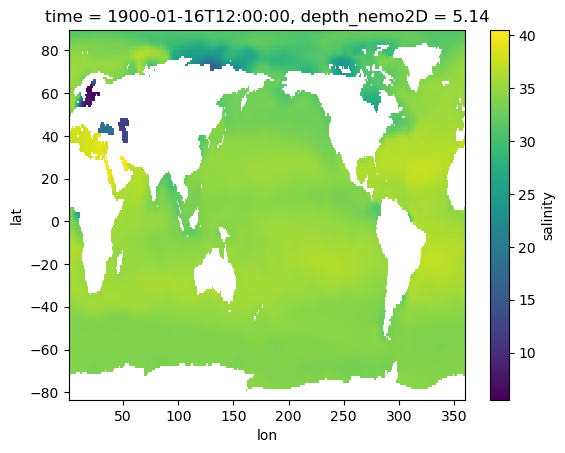

In [20]:
salt_on_levt.isel(depth_nemo2D=4).plot()

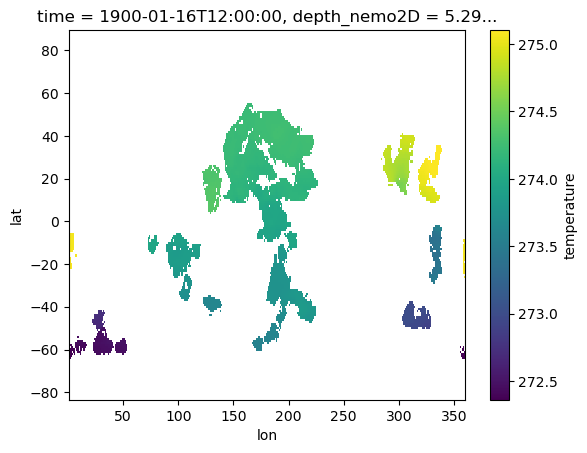

In [21]:
temp_on_levt.isel(depth_nemo2D=71).plot()

In [22]:
salt_on_levt[0,:,:,0]=salt_on_levt[0,:,:,4]
salt_on_levt[0,:,:,1]=salt_on_levt[0,:,:,4]
salt_on_levt[0,:,:,2]=salt_on_levt[0,:,:,4]
salt_on_levt[0,:,:,3]=salt_on_levt[0,:,:,4]
salt_on_levt[0,:,:,72]=salt_on_levt[0,:,:,71]
salt_on_levt[0,:,:,73]=salt_on_levt[0,:,:,71]
salt_on_levt[0,:,:,74]=salt_on_levt[0,:,:,71]

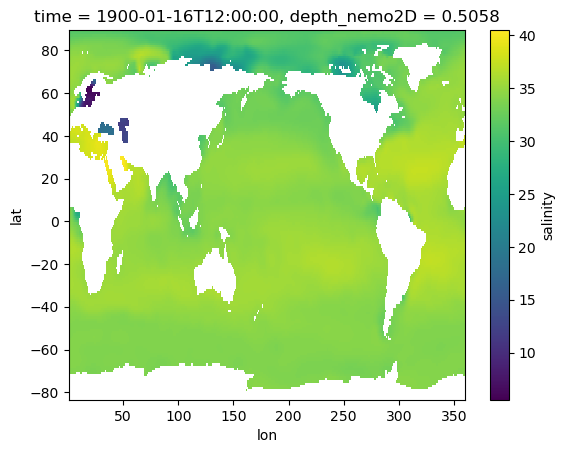

In [23]:
salt_on_levt.isel(depth_nemo2D=0).plot()

In [24]:
temp_on_levt[0,:,:,0]=temp_on_levt[0,:,:,4]
temp_on_levt[0,:,:,1]=temp_on_levt[0,:,:,4]
temp_on_levt[0,:,:,2]=temp_on_levt[0,:,:,4]
temp_on_levt[0,:,:,3]=temp_on_levt[0,:,:,4]
temp_on_levt[0,:,:,72]=temp_on_levt[0,:,:,71]
temp_on_levt[0,:,:,73]=temp_on_levt[0,:,:,71]
temp_on_levt[0,:,:,74]=temp_on_levt[0,:,:,71]

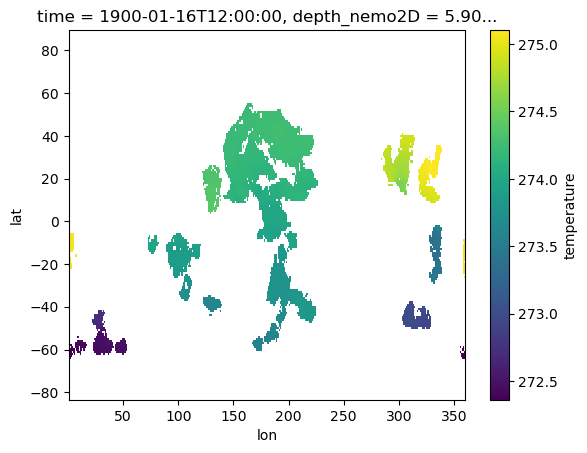

In [25]:
temp_on_levt.isel(depth_nemo2D=74).plot()

In [26]:
# Create a dataset to use ds.to_netcdf to write both vertical remap variables
ds = xr.Dataset(dict(lat=(('y_s', 'x_s'), lats.values), 
                     lon=(('y_s', 'x_s'), lons.values),
                     time=(('time_s'), dfs.time.values),
                     depth=(('new_depth_s'), salt_on_levt.depth_nemo2D.values),
                     salinity=(('time','y_s', 'x_s', 'depth'), salt_on_levt.data),
                     temperature=(('time','y_s', 'x_s', 'depth'), temp_on_levt.data)
                   ))

ds.lat.attrs = dict(standard_name='latitude', long_name='latitude', units='degrees_north', _FillValue = -32767)
ds.lon.attrs = dict(standard_name='longitude', long_name='longitude', units='degrees_east', _FillValue = -32767)

ds.coords['time'] = ds.time
ds.coords['lat'] = ds.lat
ds.coords['lon'] = ds.lon
ds.coords['depth'] = ds.depth

# Merge to have both in the same `xarray.Dataset`
# ds=xr.merge([salinity,temperature])

In [27]:
fileinterp="EN4_salt_temp_on_l75.nc"
ds.to_netcdf(dir_out+fileinterp)

In [28]:
end = t.time()
print('Runtime to apply the weights to the data in filein is', '{0:.1f}'.format(end - begin), 's')

Runtime to apply the weights to the data in filein is 2.5 s
